## Simbad cone search

This notebook show he to build SkyCoord object from the outpour of a Simbad CS output

- The query is centered on the Barnard's star in order to clearly visualize the proper motion.
- Output are plotted on matplotlib scatter


In [8]:
%matplotlib widget

import sys
import os
import logging
import matplotlib
import mplcursors
import matplotlib.pyplot as plt 
import numpy as np
from astropy.io.votable import parse
from astropy.visualization import astropy_mpl_style
from astropy.coordinates import SkyCoord
from astropy.time import Time
import astropy.units as u

from pyvo.dal.scs import SCSService

from pyvo.mivot.viewer.mivot_viewer import MivotViewer
from pyvo.mivot.features.sky_coord_builder import SkyCoordBuilder
from pyvo.mivot.utils.dict_utils import DictUtils
from pyvo.mivot.utils.xml_utils import XmlUtils

from pyvo.utils import activate_features
from pyvo.dal.scs import SCSService

activate_features("MIVOT")


A few function used for the plots

In [9]:

def add_tooltips(scatter, texts):
    cursor = mplcursors.cursor(scatter, hover=True)

    @cursor.connect("add")
    def on_add(sel):
        sel.annotation.set_text(texts[sel.index])
        sel.annotation.get_bbox_patch().set(fc="yellow", alpha=1)  # style optionnel
        sel.annotation.set_ha("left") 
        
def build_scatter(subplot, ra, decs, text, color):
    subplot.ticklabel_format(useOffset=False)
    scatter =  subplot.scatter(ras, decs, color=color)
    for i, txt in enumerate(text):
        subplot.annotate(txt[:6], (ras[i], decs[i]))
    return scatter
    
def setup_plot():
    _, ax = plt.subplots()
    plt.title(f"Simbed CS on {RA} {DEC} R={SR}")
    plt.xlabel("RA")
    plt.ylabel("DEC")
    return ax



Query parameters required by PYVO SCS

In [10]:

SERVER = "https://simbad.cds.unistra.fr/cone?"
RA = 269.452076* u.degree
DEC = 4.6933649* u.degree
SR = 0.1* u.degree
MAXREC = 100


Run the query and print out the mapping block

In [11]:
matplotlib.pyplot.close("all")
scs_srv = SCSService(SERVER)
VERB = 1

dates =[]
ras = []
decs = []

query_result = scs_srv.search(
    pos=SkyCoord(ra=RA, dec=DEC, frame='icrs'), radius=SR,
    verbosity=VERB,
    RESPONSEFORMAT="mivot",
    MAXREC=MAXREC)
# The MIVOt viewer generates the model view of the data
m_viewer = MivotViewer(query_result, resolve_ref=True)
# Get the first instance mapped in the MIVOt <TEMPLATES>
XmlUtils.pretty_print(m_viewer._mapping_block)

<VODML>
  <REPORT status="OK">
  </REPORT>
  <MODEL name="ivoa" url="https://www.ivoa.net/xml/VODML/IVOA-v1.vo-dml.xml">
  </MODEL>
  <MODEL name="coords" url="https://ivoa.net/xml/VODML/Coords-v1.vo-dml.xml">
  </MODEL>
  <MODEL name="mango" url="https://raw.githubusercontent.com/ivoa-std/MANGO/refs/heads/wd-v1.0/vo-dml/mango.vo-dml.xml">
  </MODEL>
  <GLOBALS>
    <INSTANCE dmtype="coords:SpaceSys" dmid="_spaceframe_ICRS_2000_BARYCENTER">
      <INSTANCE dmtype="coords:SpaceFrame" dmrole="coords:PhysicalCoordSys.frame">
        <ATTRIBUTE dmtype="ivoa:string" dmrole="coords:SpaceFrame.spaceRefFrame" value="ICRS">
        </ATTRIBUTE>
      </INSTANCE>
    </INSTANCE>
  </GLOBALS>
  <TEMPLATES>
    <INSTANCE dmtype="mango:MangoObject" dmid="main_id">
      <ATTRIBUTE dmtype="ivoa:string" dmrole="mango:MangoObject.identifier" ref="main_id">
      </ATTRIBUTE>
      <COLLECTION dmrole="mango:MangoObject.propertyDock">
        <INSTANCE dmtype="mango:EpochPosition">
          <ATTRIBUTE 

Plot all positions found in the query response

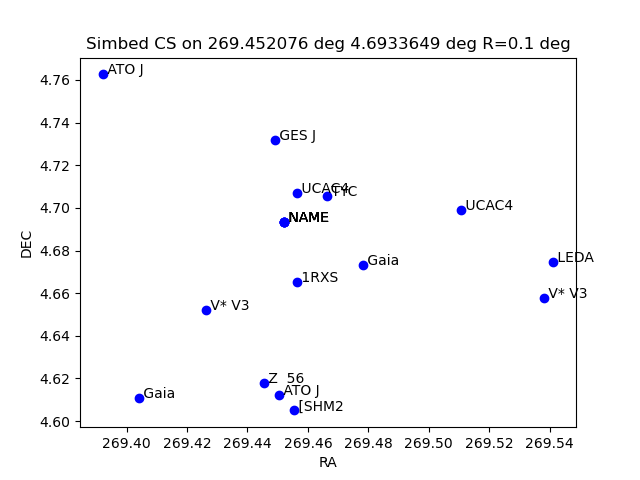

In [12]:
matplotlib.pyplot.close("all")
VERB = 2
query_result = scs_srv.search(
    pos=SkyCoord(ra=RA, dec=DEC, frame='icrs'), radius=SR,
    verbosity=VERB,
    RESPONSEFORMAT="mivot", MAXREC=MAXREC)
# The MIVOt viewer generates the model view of the data
m_viewer = MivotViewer(query_result, resolve_ref=True)
# Get the first instance mapped in the MIVOt <TEMPLATES>
# XmlUtils.pretty_print(m_viewer._mapping_block)

dates =[]
ras = []
decs = []
now_ras = []
now_decs = []
mango_labels = []

mivot_instance = m_viewer.dm_instance
if mivot_instance.dmtype == "mango:MangoObject":
    mango_properties = mivot_instance.propertyDock
    for mango_property in mango_properties:
        if mango_property.dmtype == "mango:Label":    
            mango_labels.append(mango_property)
    # iterate over the table rows
    while m_viewer.next_row_view():

        scb = SkyCoordBuilder(mivot_instance)
        sky_coord = scb.build_sky_coord()
        lm = ""
        for mango_label in mango_labels:
            description = mango_label.description.value
            value = mango_label.text.value if mango_label.text.value else "-"
            lm += f"{description}: {value}\n"
        dates.append(f" {mivot_instance.identifier.value}\nobstime: {sky_coord.obstime}\n{lm} {str(sky_coord)}")
        ras.append(sky_coord.ra.deg)
        decs.append(sky_coord.dec.deg)

ax = setup_plot()
scatter = build_scatter(ax, ras, decs, dates, "blue")    
add_tooltips(scatter, dates)        

Plot all positions foud in the query response now and in 2023.

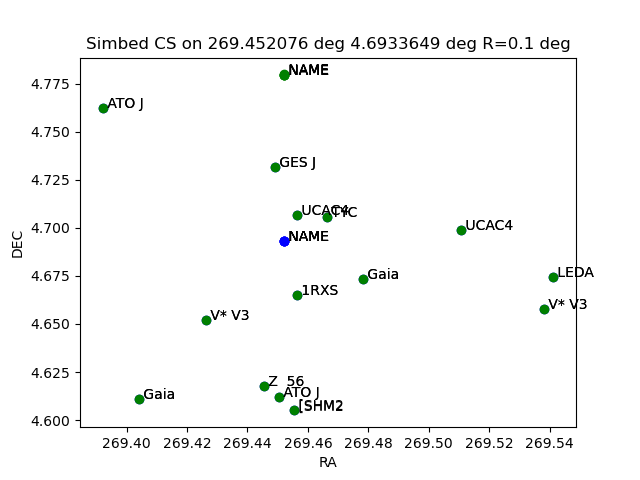

In [13]:
matplotlib.pyplot.close("all")
VERB = 2
query_result = scs_srv.search(
    pos=SkyCoord(ra=RA, dec=DEC, frame='icrs'), radius=SR,
    verbosity=VERB,
    RESPONSEFORMAT="mivot", MAXREC=MAXREC)
# The MIVOt viewer generates the model view of the data
m_viewer = MivotViewer(query_result, resolve_ref=True)
# Get the first instance mapped in the MIVOt <TEMPLATES>
# XmlUtils.pretty_print(m_viewer._mapping_block)

dates =[]
future_dates =[]
ras = []
decs = []
future_ras = []
future_decs = []
mango_labels = []

mivot_instance = m_viewer.dm_instance
if mivot_instance.dmtype == "mango:MangoObject":
    mango_properties = mivot_instance.propertyDock
    for mango_property in mango_properties:
        if mango_property.dmtype == "mango:Label":    
            mango_labels.append(mango_property)
    # iterate over the table rows
    while m_viewer.next_row_view():

        scb = SkyCoordBuilder(mivot_instance)
        sky_coord = scb.build_sky_coord()
        lm = ""
        for mango_label in mango_labels:
            description = mango_label.description.value
            value = mango_label.text.value if mango_label.text.value else "-"
            lm += f"{description}: {value}\n"
        dates.append(f" {mivot_instance.identifier.value}\nobstime: {sky_coord.obstime} \n{lm}{str(sky_coord)}")
        ras.append(sky_coord.ra.deg)
        decs.append(sky_coord.dec.deg)
        try:
            sky_coord_future = sky_coord.apply_space_motion(new_obstime=Time('J2030'))
            future_ras.append(sky_coord_future.ra.deg)
            future_decs.append(sky_coord_future.dec.deg)
            future_dates.append(f"{mivot_instance.identifier.value}\n"
                                f"obstime:{sky_coord_future.obstime} \n"
                                f"{lm}{str(sky_coord_future)}")
        except Exception:
            future_ras.append(sky_coord.ra.deg)
            future_decs.append(sky_coord.dec.deg)
            future_dates.append(f" {mivot_instance.identifier.value}\nobstime: 2025.5 \n {lm}{str(sky_coord)}")

ax = setup_plot()
scatter = build_scatter(ax, ras, decs, dates, "blue")
add_tooltips(scatter, dates)

scatter_future = build_scatter(ax, future_ras, future_decs, dates, "green")
add_tooltips(scatter_future, future_dates)        